In [1]:
import pickle
import os
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler 
import sys
sys.path.insert(0, "../../shared_sources")
import torchvision
import soundfile

import numpy as np
import torch
import matplotlib.pyplot as plt
import librosa.display
import IPython
import warnings
warnings.filterwarnings('ignore')

from torchvision.utils import make_grid 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load scaler and generator

In [2]:
gen = torch.load("gen3-24099.torch").to(device).eval()
scaler = pickle.load(open("../../shared_sources/fitted_maxabsscalerx80.sav", 'rb'))

# load target images

In [3]:
with open('target_images_great_tit.pkl', 'rb') as f:
     targets_great_tit = pickle.load(f)

In [4]:
with open('target_images_willow_warbler.pkl', 'rb') as f:
     targets_willow_warbler = pickle.load(f)

In [5]:
with open('target_images_eurasian_wren.pkl', 'rb') as f:
     targets_eurasian_wren = pickle.load(f)

# load waveglow vocoder

In [6]:
waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_waveglow')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)

Using cache found in /home/fabi/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub


# init functions to sample from latentspace

In [7]:
def create_samples(gen, times, num_samples = 100):
    nns = []
    originals=[]
    ls_vectors =[]
    with torch.no_grad():
        for i in range(times):
            noise = torch.randn(num_samples, 100, 1, 1).to(device)
            d = gen(noise).cpu().numpy()
            if ls_vectors == []:
                ls_vectors = torch.tensor(noise)
            else:
                ls_vectors = torch.cat((ls_vectors,torch.tensor(noise)))
                
            for i in range(num_samples):
                d[i] = StandardScaler().fit_transform(np.reshape(d[i],(80,80)))
            if nns == []:
                nns = torch.tensor(d)
            else:
                nns = torch.cat((nns,torch.tensor(d)))
    nns = torch.reshape(nns, (times * num_samples,80*80))
    return ls_vectors, nns


def plot_mel(mel):
    mel = scaler.inverse_transform(mel)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(mel, sr=22050,
                             fmax=22050/2, ax=ax)
    fig.show()
    
    
def play_audio(audio):
    IPython.display.display(IPython.display.Audio(audio, rate=22050))
    
def create_wav(mel):
    mel = scaler.inverse_transform(mel)
    with torch.no_grad():
            mel = torch.Tensor(mel).unsqueeze(0)
            audio = waveglow.infer(mel.to(device))
    return audio.cpu()

def save_audio_to_file(audio, filename):
    soundfile.write("nn_examples/" + filename, audio, 22050)
    

def create_wave_and_mel(data_path, sampling_rate=22050, offset=0):
    audio,_ = librosa.load(data_path, sr=sampling_rate, duration=0.92, offset=offset)
    t = torch.Tensor(audio).unsqueeze(0)
    mel = np.reshape(calc_mel.mel_spectrogram(t,False), (80,80))
    return audio, mel

def find_nn(target, image_space, neighbours = 5):
    t = StandardScaler().fit_transform(target)
    t = np.reshape(t,(80*80))

    dist = torch.norm(image_space - t, dim=1, p=None)
    knn = dist.topk(neighbours, largest=False)
    return knn[1]

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
def morph(gen, vec1, vec2, steps):
    with torch.no_grad():
        ret = []
        for i in range(steps):
            v = (vec1 * (1 - i/steps)) + (vec2 * i/steps)
            ret.append(gen(v).cpu())
    return ret

def multiple_morph(gen, ls_vectors, lst, steps):
    with torch.no_grad():
        ret = []
        for i in range(len(lst)):
            vec1 = ls_vectors[lst[i]].unsqueeze(0)
            if i+1 != len(lst):
                nxt = i+1
            else:
                nxt = 0
                    
            vec2 = ls_vectors[lst[nxt]].unsqueeze(0)
            for step in range(steps):
                v = (vec1 * (1 - step/steps)) + (vec2 * step/steps) 
                ret.append(gen(v).cpu())
    return ret



def audio_from_morphed(mor):
    full_wav = []
    with torch.no_grad():
        for mel in mor:
            mel = mel.squeeze()
            wav = create_wav(mel)
            if full_wav == []:
                full_wav = wav
            else:
                full_wav = np.concatenate((full_wav, wav), 1)
    return full_wav

def find_nn_by_targets(targets):
    ls_indexes = []
    with torch.no_grad():
        for i in list(targets):
            print(i)
            tar = targets[i]
            t = np.reshape(tar.numpy(),(80,80))
            s = torch.Tensor(6,1,80,80)
            idx = find_nn(t, nn_space).numpy()
            #plot_mel(t)
            audio = create_wav(t)
            #save_audio_to_file(audio[0],'willow_warbler-original_' + str(i) + ".wav")
            play_audio(audio)
            ls_indexes.append(idx)
            s[0] = tar
            i2 = 1
            if True:
                for i3 in idx:
                    orig = gen(torch.reshape(ls_vectors[i3],(1,100,1,1)))
                    im = np.reshape(orig.cpu().detach().numpy(),(80,80))
                    s[i2] = orig
                    i2 += 1
                    audio = create_wav(im)
                    #save_audio_to_file(audio[0],'willow_warbler_' + str(i) + "_nn_" + str(i2) + ".wav")
                    play_audio(audio)
                img_grid = make_grid(s, normalize=True,nrow=6)
                imshow(img_grid)
            #torchvision.utils.save_image(img_grid, 'nn_examples/willow_warbler_-sample_' + str(i) + '.png', normalize=True)
    return ls_indexes

# get 10.000 samples of generated birdsongs

In [8]:
ls_vectors, nn_space = create_samples(gen,100,100)

# find nn from great tit

0


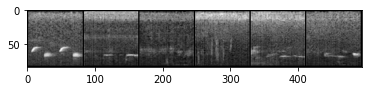

1


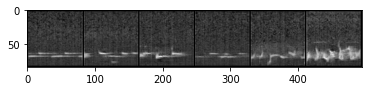

2


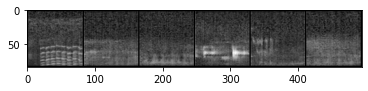

3


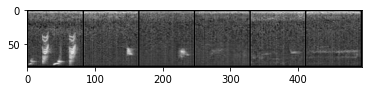

5


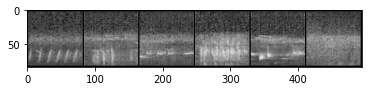

4


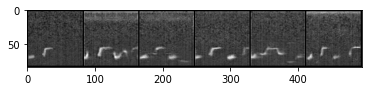

In [9]:
idx_gt = find_nn_by_targets(targets_great_tit)

## find nn from willow warbler

0


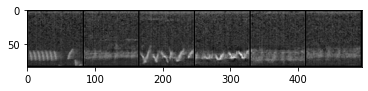

1


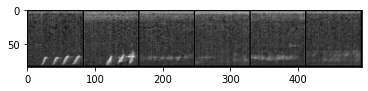

2


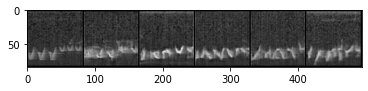

3


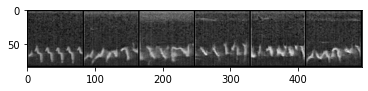

4


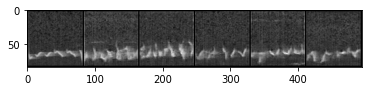

5


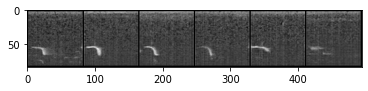

In [10]:
idx_ww = find_nn_by_targets(targets_willow_warbler)

# find nn from eurasian wren

0


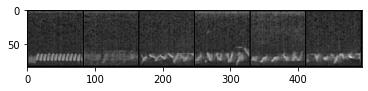

1


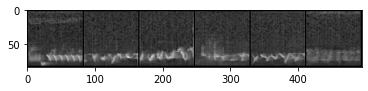

2


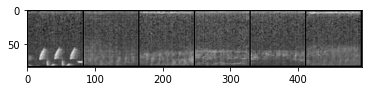

3


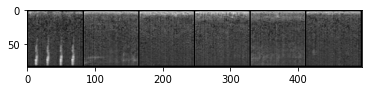

[array([7307, 6754, 4260, 3718, 7614]),
 array([7614, 4444, 2681, 6754, 7813]),
 array([8078, 9137, 1855,  289, 6122]),
 array([5368, 7803, 7817, 9953, 9727])]

In [11]:
find_nn_by_targets(targets_eurasian_wren)

# morph trough nearest neighbours

In [12]:
mor = multiple_morph(gen,ls_vectors, [idx_gt[0][0], idx_ww[0][1], idx_gt[1][1], 
                                      idx_ww[1][0], idx_gt[3][0], idx_ww[2][0], idx_ww[4][0], idx_ww[3][0],
                                     idx_gt[5][0], idx_ww[5][0]],5)

toplay = audio_from_morphed(mor)
play_audio(toplay)

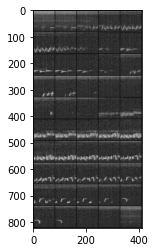

In [15]:
mor_grids = torch.Tensor(len(mor),1,80,80)
for i in range(len(mor)):
    mor_grids[i] = mor[i].squeeze()
img_grid = make_grid(mor_grids, normalize=True,nrow=5)
imshow(img_grid)